#Logistic Regession VS Random Forest on breast cancer dataset

**Notebook goal**: 

This notebook was created in the process of studying the concepts of ***ROC (Recieving Operator Curve)*** and ***AUC (Area Under the Curve)***. The following analysis implements the ROC and AUC to compare the performance of two classification models, one Logistic Regression and one Random Forest model.

**Dataset**: 

Breast cancer wisconsin (diagnostic) dataset.

**Analysis objective**: 

Given  tumor's characteristics, predict if the tumor will be benign or malignant.

*by Rea Kalampaliki*

##Import Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

breast_cancer_raw = datasets.load_breast_cancer()

# create a pandas dataframe with the features and the target variable of iris dataset
breast_cancer = pd.DataFrame(breast_cancer_raw.data, columns=breast_cancer_raw.feature_names)
breast_cancer['malignant'] = breast_cancer_raw.target
print(breast_cancer_raw.target_names)
print(breast_cancer.shape)
breast_cancer.head()

['malignant' 'benign']
(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,malignant
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
for clue in breast_cancer_raw.DESCR.split('\n'):
    print(clue)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

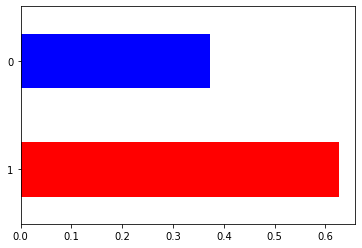

In [5]:
from itertools import cycle, islice
my_colors = list(islice(cycle(['r', 'b']), None, len(breast_cancer)))
(breast_cancer['malignant'].value_counts()/breast_cancer['malignant'].value_counts().sum()).plot.barh(stacked=True, color=my_colors)

Sample consistency: 60% malignant - 40% benign tumors

In [6]:
breast_cancer.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
malignant                  0
dtype: int64

Breast cancer dataset has no missing values, so we don't need to apply any missing values treatment.

In [7]:
breast_cancer.duplicated().sum()

0

## Descriptive statistics

In [8]:
breast_cancer.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,malignant
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


##Data features - target split

In [9]:
# features - target split
bc_X = breast_cancer.drop('malignant', axis=1)
bc_y = breast_cancer['malignant']

## Rescaling


There are three types of feature columns in our dataset:
- Mean containing
- Error containing
- "Worst" (Maximum) containing

By definition `mean, max >> error`.

Is getting more obvious that we need to standardize the features of our dataset, to facilitate models' building later on the analysis.

By examing the table with the descriptive statistics of our features (generated above) we understand that they contain outliers. So, we choose `RobustScaler` to do the standardization.

In [16]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(bc_X)
bc_X= scaler.transform(bc_X)

print("Median:", scaler.center_)
print("Interquantile Range:", scaler.scale_)

Median: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Interquantile Range: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


## Data train - test split

In [12]:
# train - test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bc_X, bc_y, test_size=0.2)

print("Number of rows of the original dataset:", breast_cancer.shape[0])
print("Number of rows of the train dataset:", X_train.shape[0])
print("Number of rows of the test dataset:", X_test.shape[0])

Number of rows of the original dataset: 569
Number of rows of the train dataset: 455
Number of rows of the test dataset: 114


## Models building and evaluation

We deal with a binary classification problem.

To make the predictions we are going to build one Logistic Regression and one Random Forest model and pick the best out of two.

We are going to compare the two models on AUC.

In [13]:
# define a function for easie ROC plotting
def plot_ROC(name, true_positive_rate, false_positive_rate, AUC, figure_size=(5,5)):
    plt.figure(figsize=figure_size)
    plt.plot(false_positive_rate, true_positive_rate)
    plt.title(f'{name}: {AUC:0.5f}', fontsize=18)
    plt.ylabel("True positive rate")
    plt.xlabel("False positive rate")
    plt.plot([0, 1], ls="--")
    plt.show()

In [ ]:
# create the models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

names = ['Logistic Regression', 'Random Forest']

models = [LogisticRegression(),
          RandomForestClassifier(n_estimators=50, n_jobs=-1)]

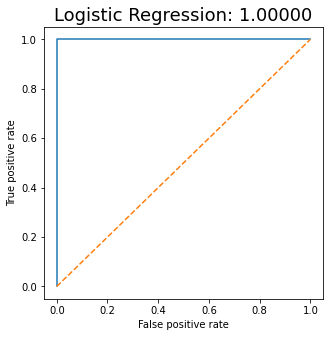

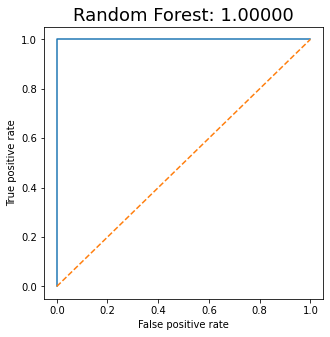

In [ ]:
 # use a loop to fit the models on training dataset, 
 # make predictions on test dataset 
 # and evaluate the models using ROC and AUC

 from sklearn.metrics import roc_curve, roc_auc_score

 for name, model in zip(names, models):
     model.fit(X_train, y_train)
     pred_score = model.predict_proba(X_test)[:,1]
     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, pred_score)
     AUC =  roc_auc_score(y_test, pred_score)
     plot_ROC(name, true_positive_rate, false_positive_rate, AUC)

Based on AUC, both models perfom perfecly on our data.